## **Aplicação de Regressão Linear Simples e Múltipla**
Neste notebook são aplicados os modelos de regressão linear simples e múltipla, bem como a construção de features para captura de sazonalidade e outras características das séries temporais.
Para avaliação do desempenho do modelo, serão utilizadas as métricas **MAE**, **MSE**, **RMSE** e **R²**, comparados aos modelos baseline **SARIMA** e **ETS**. 

In [1]:
# confirgurando diretório
import sys
import os
sys.path.append(os.path.abspath('..'))

# importando bibliotecas
import warnings
import swifter # parelelismo
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from statsforecast import StatsForecast 
from statsforecast.models import SeasonalNaive, AutoARIMA, AutoETS 
from src.outliers import detect_outliers
from src.features import add_calendar_features
from src.evaluation import Evaluation
from src.plots import plot_time_series, plot_metrics


# configurando notebook
warnings.filterwarnings("ignore")
pd.set_option('display.float_format', lambda x: '%.2f' % x)


# configuração de estilo
sns.set_theme(context='paper')
plt.rcParams["figure.dpi"] = 150


%load_ext autoreload
%autoreload 2

In [2]:
# constantes
EVAL_PATH = 'data/evaluation.csv'

## **Leitura dos Dados**
Leitura dos dados de treino e teste exportados no notebook *analise_exploratoria.ipynb*. Para cada série, foram separados os 70% primeiros pontos de dados para treino e o restante, ou seja, os dados mais recentes, para teste.

In [3]:
# leitura dos dados
train_df = pd.read_csv("data/train_df.csv", parse_dates=['ds'])
test_df = pd.read_csv("data/test_df.csv", parse_dates=['ds'])

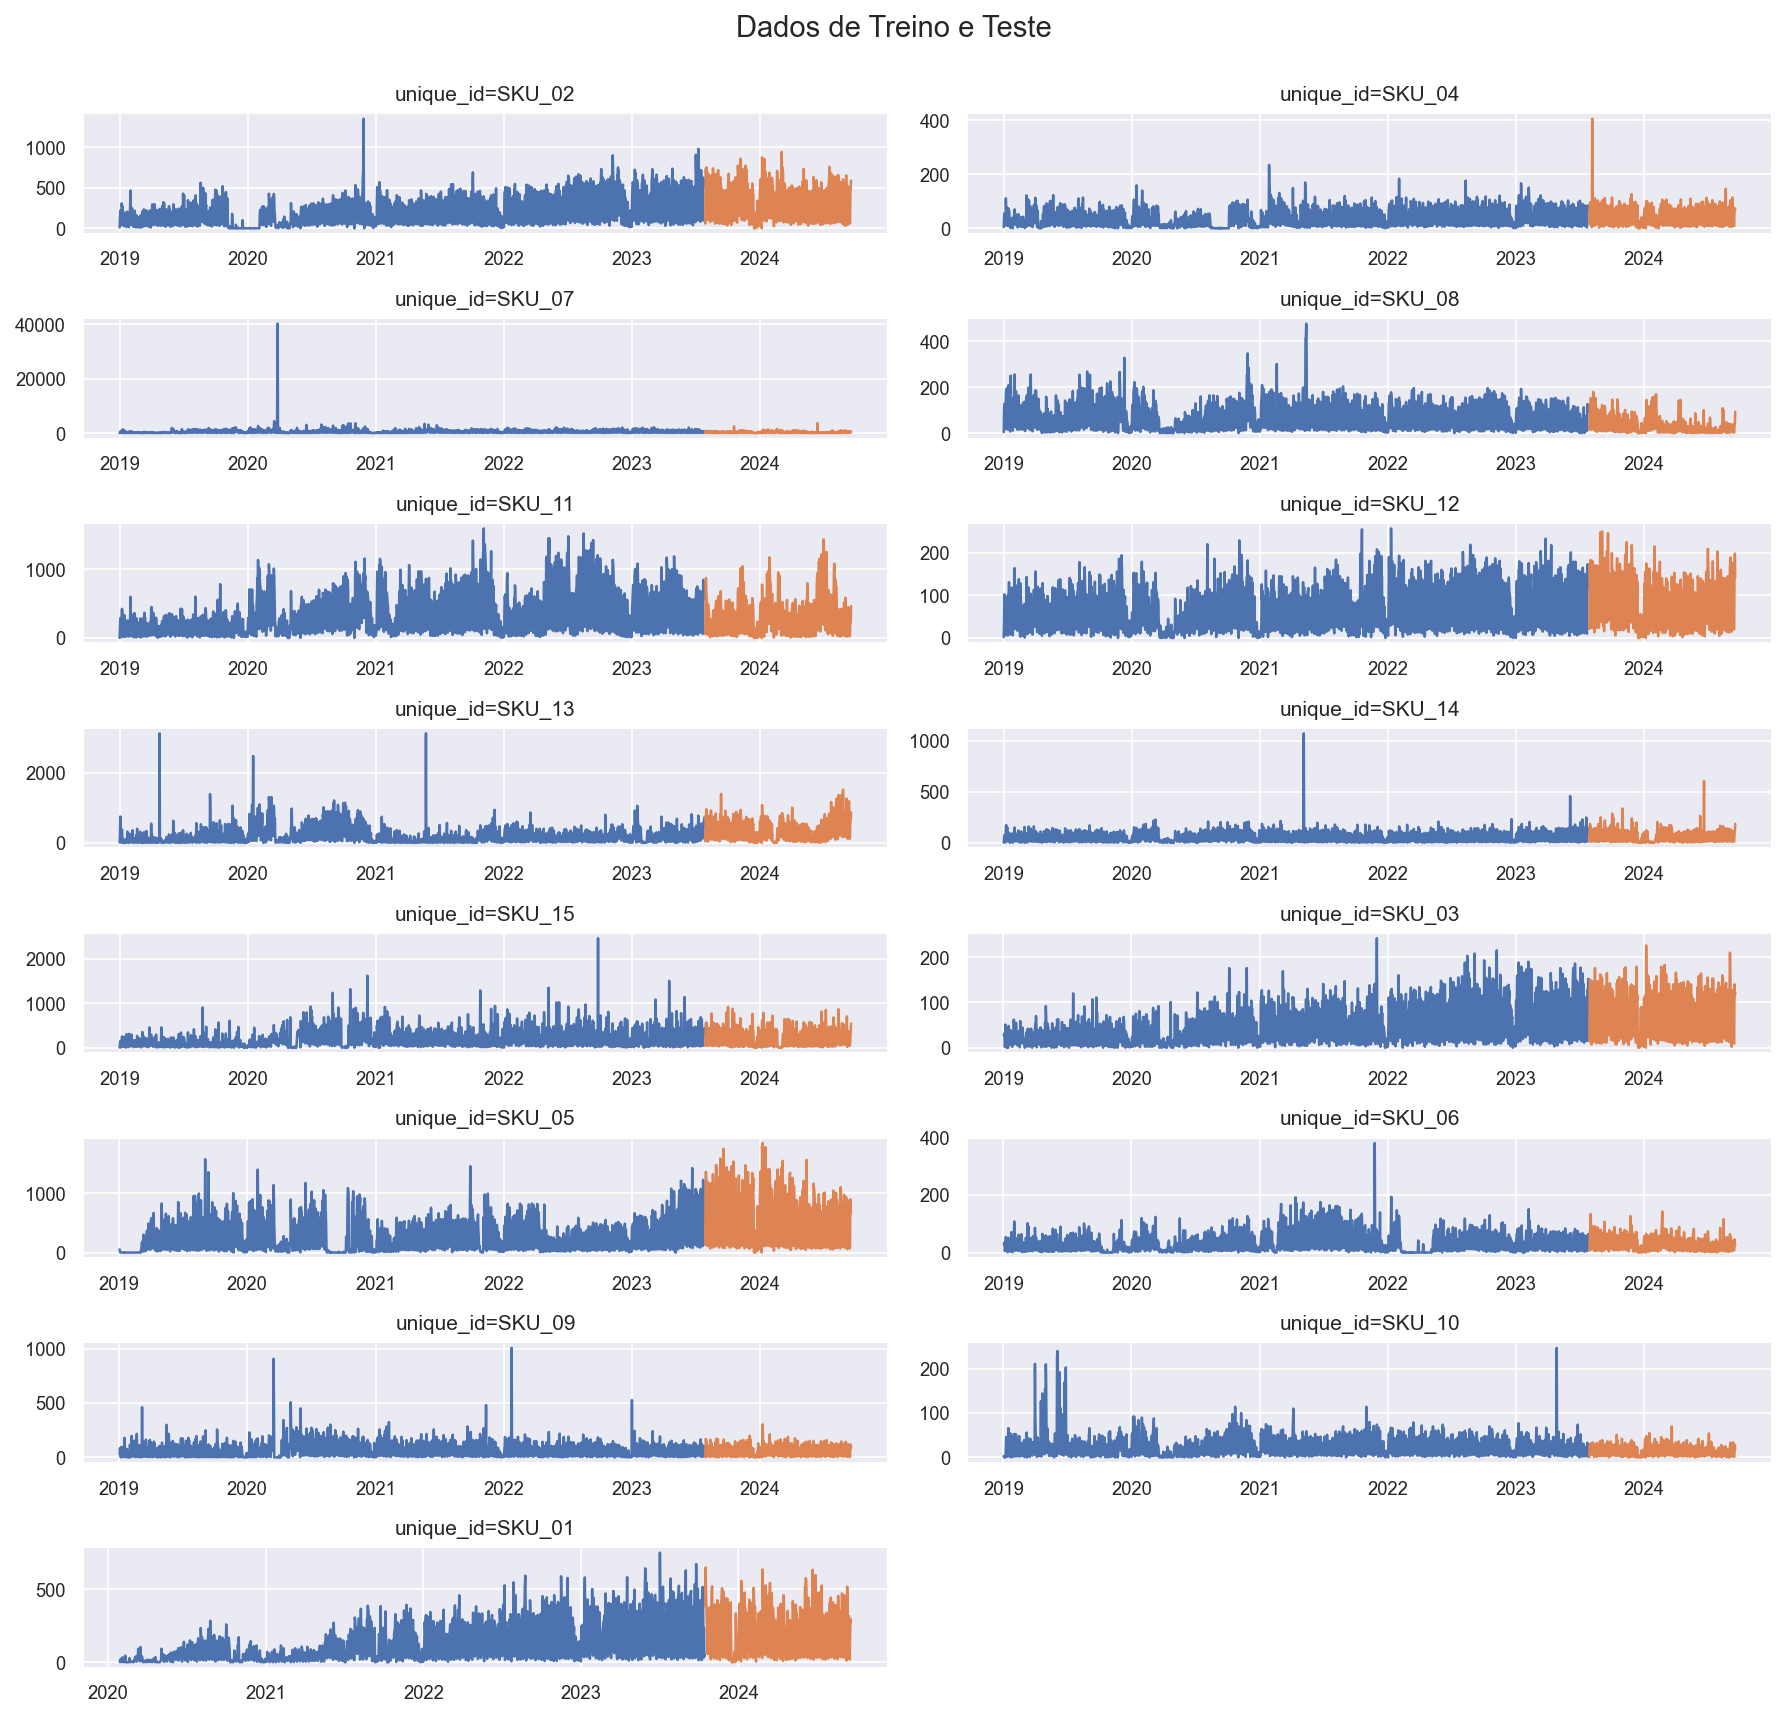

In [4]:
# visualizando dados de treino
fig1 = plot_time_series(
    df=train_df.merge(test_df, how='outer', on=['ds','unique_id'], suffixes=['_train','_test']),
    data_cols=['y_train', 'y_test'],
    title='Dados de Treino e Teste'
)

## **Modelos Baseline**
Os modelos ARIMA e ETS são modelos próprios de séries temporais, logo, serão usados para comparar com os modelos de machine learning desenvolvidos na pesquisa. Além deles, o modelo SeasonalNaive, que apenas repete os últimos valores conhecidos com base no período sazonal também será usado.

In [5]:
models = [
    SeasonalNaive(season_length=7),
    AutoETS(season_length=7),
    AutoARIMA(season_length=7)
]

sf = StatsForecast(
    models=models,
    freq='D',
    n_jobs=-1
)

def baseline_models(df):
    """
    Aplica os modelos SeasonalNaive, ETS e SARIMA.
    """
    train = df.copy().reset_index(drop=True)
    test = test_df.query("unique_id == @train.unique_id[0]").reset_index(drop=True)

    sf.fit(df=train)
    predict = sf.predict(h=len(test)).reset_index(drop=True)
    
    test['SeasonalNaive'] = predict['SeasonalNaive']
    test['ETS'] = predict['AutoETS']
    test['ARIMA'] = predict['AutoARIMA']
    
    return test

In [6]:
baseline_fcst = (
    train_df
        .swifter
        .groupby("unique_id")
        .apply(baseline_models)
        .reset_index(drop=True)
)

  0%|          | 0/15 [00:00<?, ?it/s]

2025-01-16 23:07:26,787	INFO worker.py:1821 -- Started a local Ray instance.


In [7]:
baseline_fcst.head()

unique_id         ds      y  SeasonalNaive    ETS  ARIMA
0    SKU_01 2023-10-16 385.00         463.00 394.13 421.49
1    SKU_01 2023-10-17 650.00         517.00 363.60 388.54
2    SKU_01 2023-10-18 462.00         432.00 358.44 385.12
3    SKU_01 2023-10-19 360.00          30.00 272.61 262.33
4    SKU_01 2023-10-20 240.00         236.00 347.75 358.76

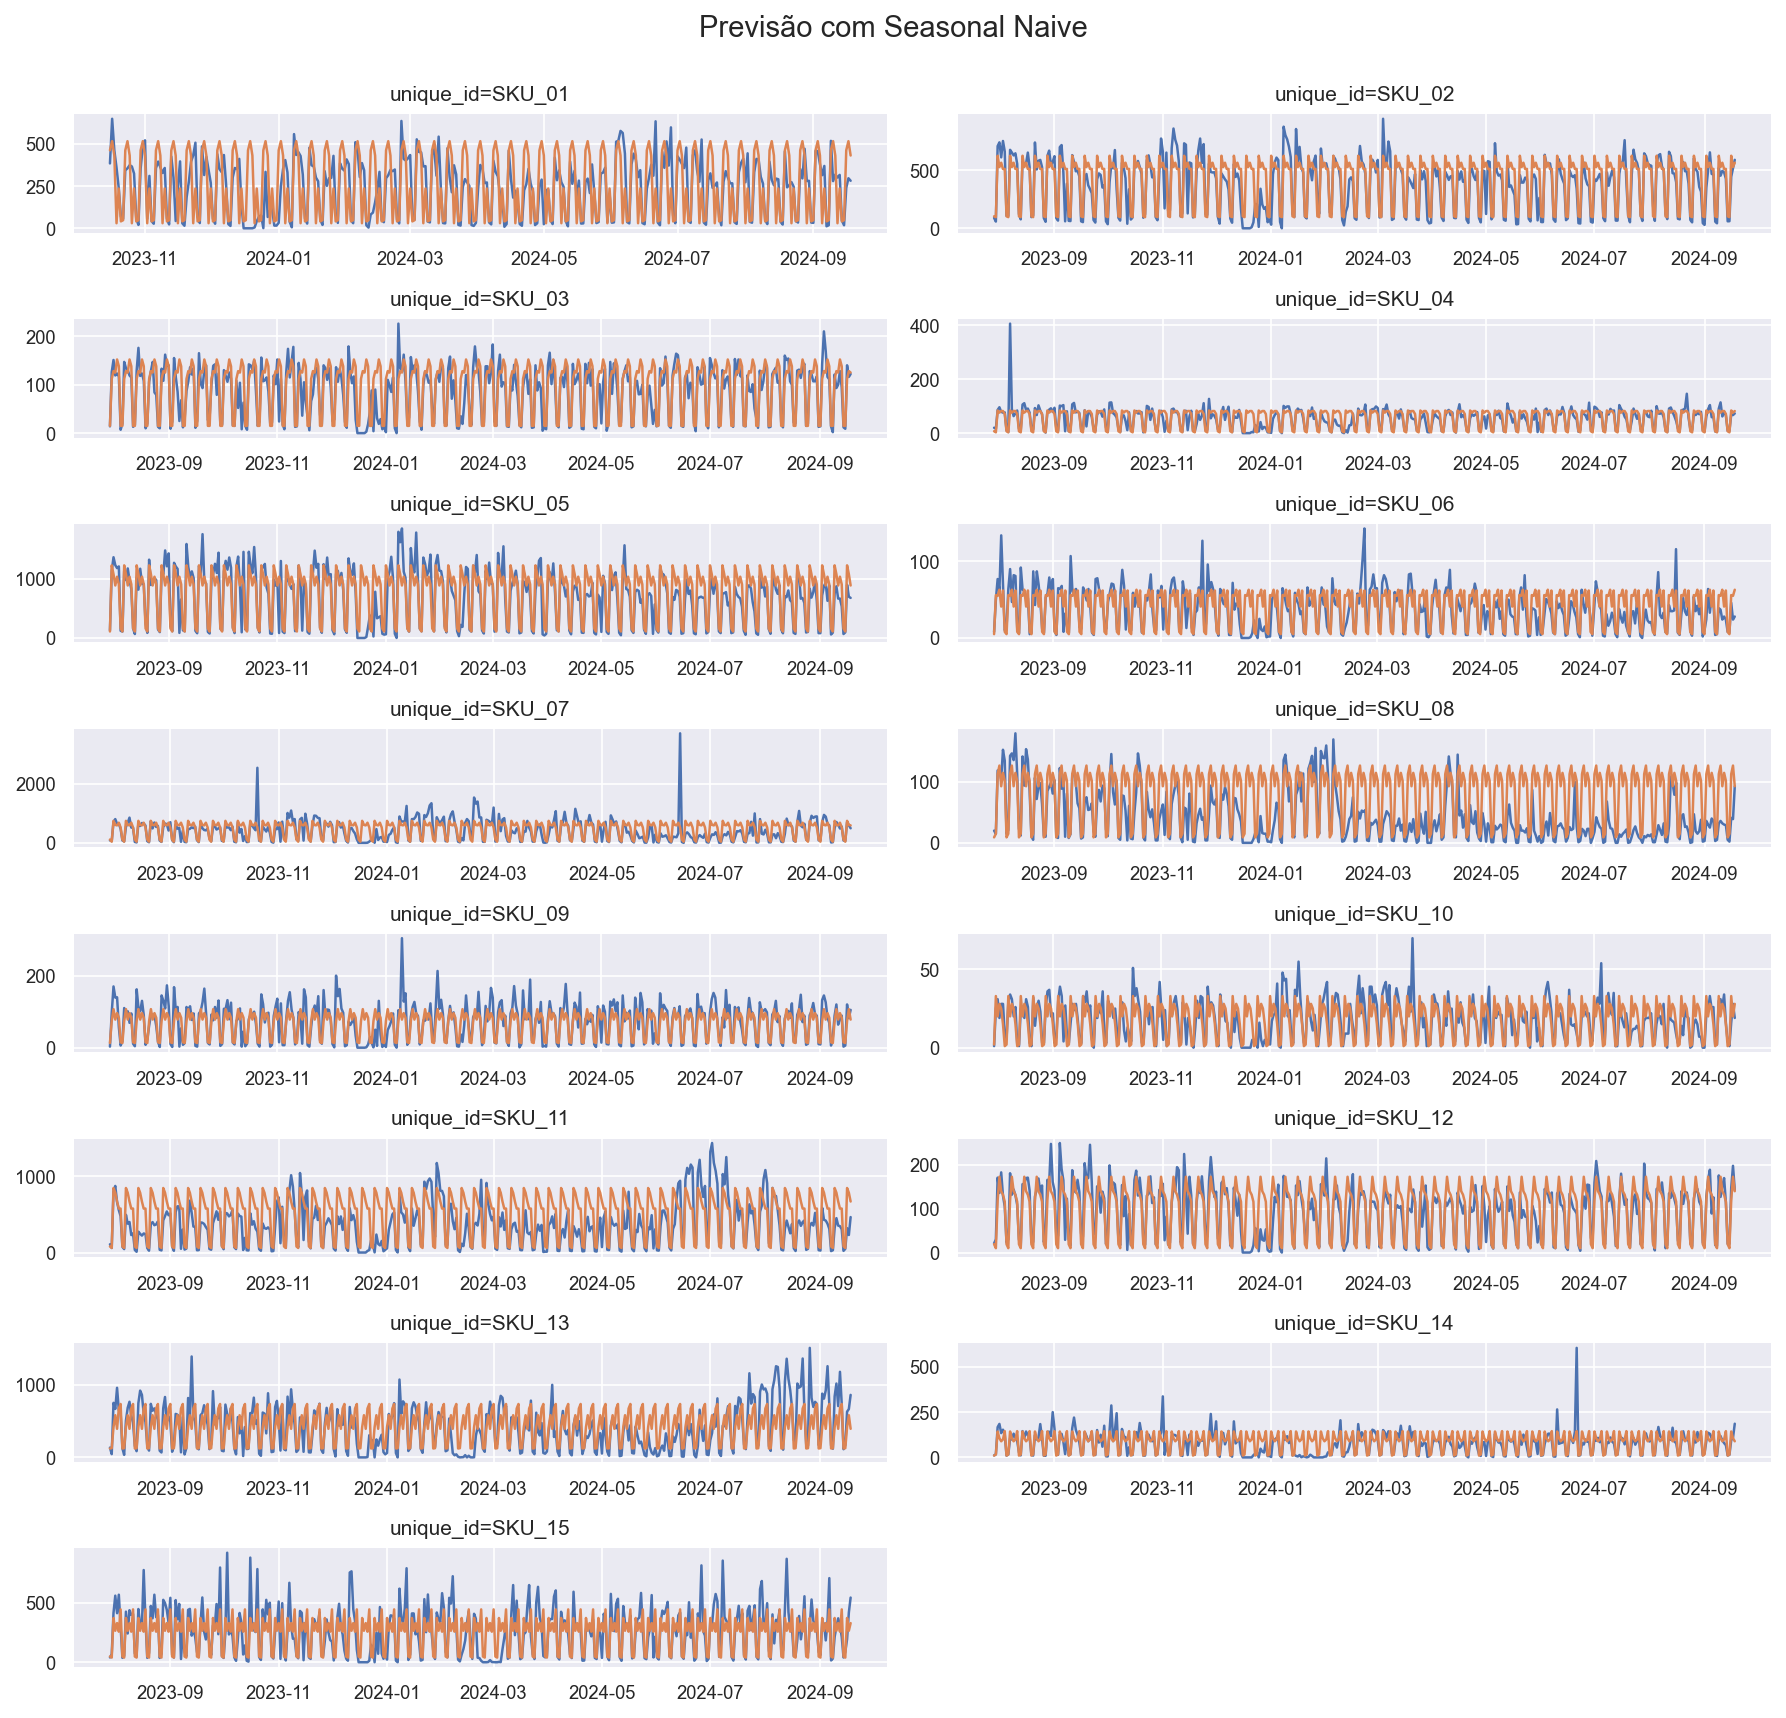

In [8]:
# plot das previsões Seasonal Naive
fig2 = plot_time_series(
    df=baseline_fcst, data_cols=['y','SeasonalNaive'], title='Previsão com Seasonal Naive'
)

In [9]:
naive_eval = Evaluation(df=baseline_fcst, y_pred_col='SeasonalNaive')
naive_eval.summary()
naive_eval.save_evaluation(EVAL_PATH, 'Naive Sazonal')
naive_eval.evaluation_df

mae      mse   rmse    r2
SKU_01 122.46 29528.68 171.84 -0.05
SKU_02  94.74 19841.01 140.86  0.62
SKU_03  25.78  1460.14  38.21  0.48
SKU_04  16.34   767.28  27.70  0.47
SKU_05 200.03 90492.28 300.82  0.58
SKU_06  14.89   441.35  21.01  0.37
SKU_07 195.35 99963.70 316.17  0.30
SKU_08  45.52  3327.93  57.69 -0.98
SKU_09  24.24  1275.97  35.72  0.52
SKU_10   7.33   102.87  10.14  0.36
SKU_11 224.25 85181.37 291.86 -0.01
SKU_12  27.96  1670.69  40.87  0.53
SKU_13 196.83 74359.87 272.69  0.25
SKU_14  32.60  2788.21  52.80  0.30
SKU_15 110.20 26085.25 161.51  0.37

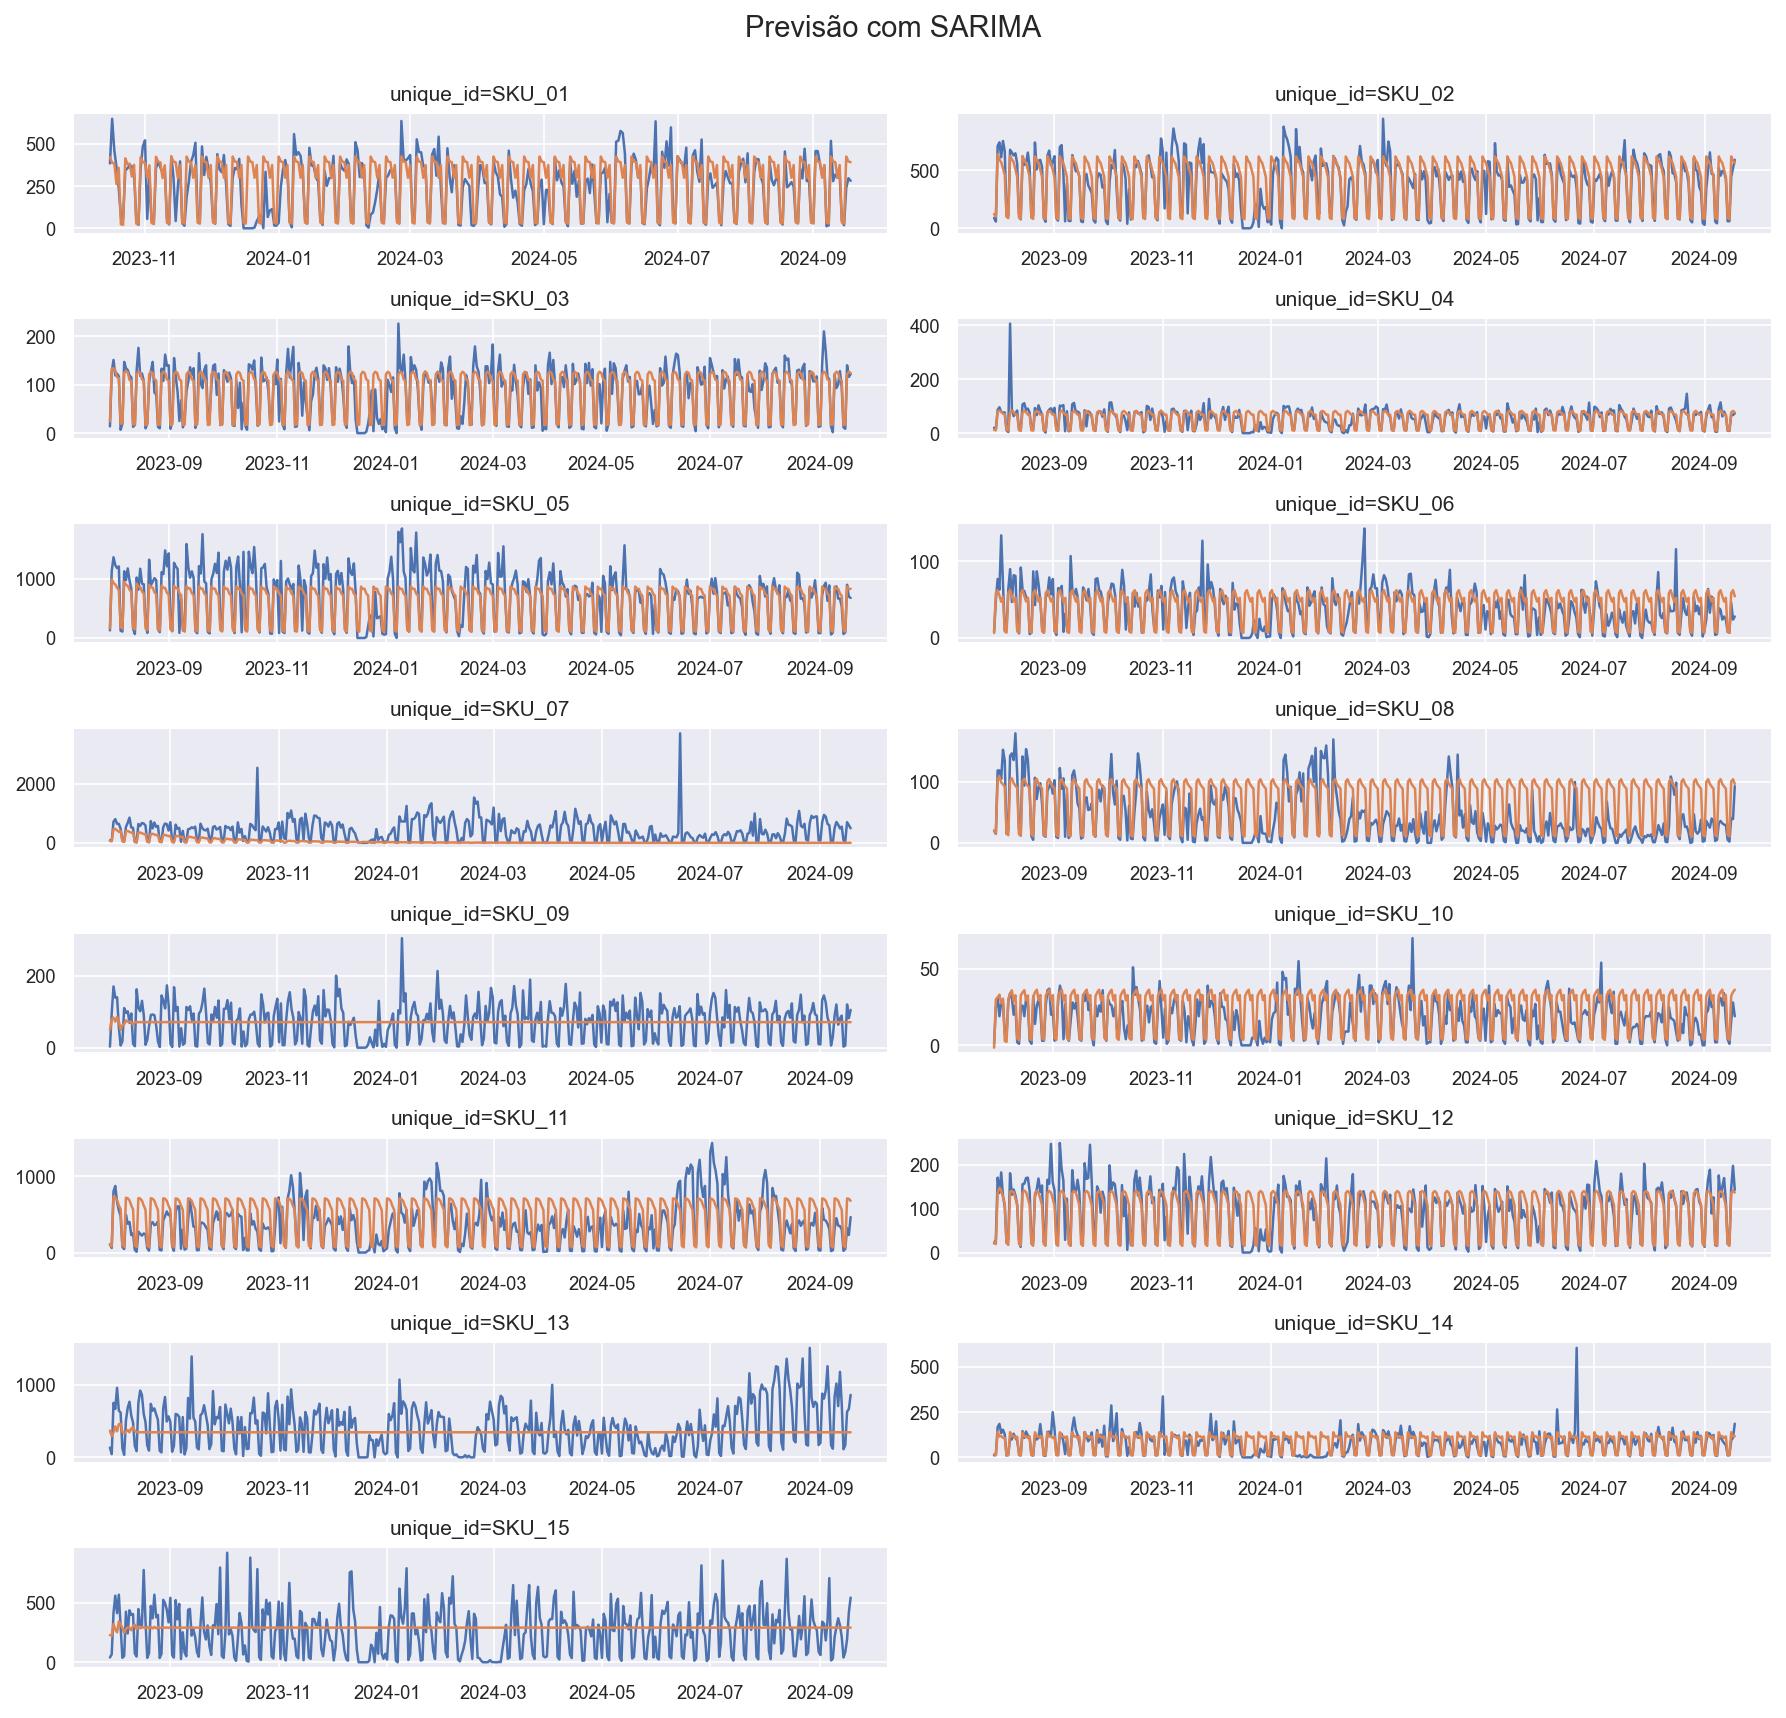

In [10]:
# plot das previsões SARIMA
fig3 = plot_time_series(
    df=baseline_fcst, data_cols=['y', 'ARIMA'], title='Previsão com SARIMA'
)

In [11]:
sarima_eval = Evaluation(df=baseline_fcst, y_pred_col='ARIMA')
sarima_eval.summary()
sarima_eval.save_evaluation(EVAL_PATH, 'SARIMA')
sarima_eval.evaluation_df

mae       mse   rmse    r2
SKU_01  74.41  12655.79 112.50  0.55
SKU_02  90.91  19036.19 137.97  0.64
SKU_03  20.43    984.75  31.38  0.65
SKU_04  14.58    697.11  26.40  0.52
SKU_05 197.36  85044.03 291.62  0.60
SKU_06  14.07    395.89  19.90  0.44
SKU_07 376.70 278923.62 528.13 -0.95
SKU_08  38.11   2346.22  48.44 -0.40
SKU_09  43.78   2629.41  51.28  0.01
SKU_10   8.85    143.53  11.98  0.10
SKU_11 207.31  70142.70 264.84  0.17
SKU_12  23.99   1326.24  36.42  0.62
SKU_13 268.35 103904.03 322.34 -0.04
SKU_14  30.09   2596.08  50.95  0.35
SKU_15 167.99  41777.34 204.40 -0.02

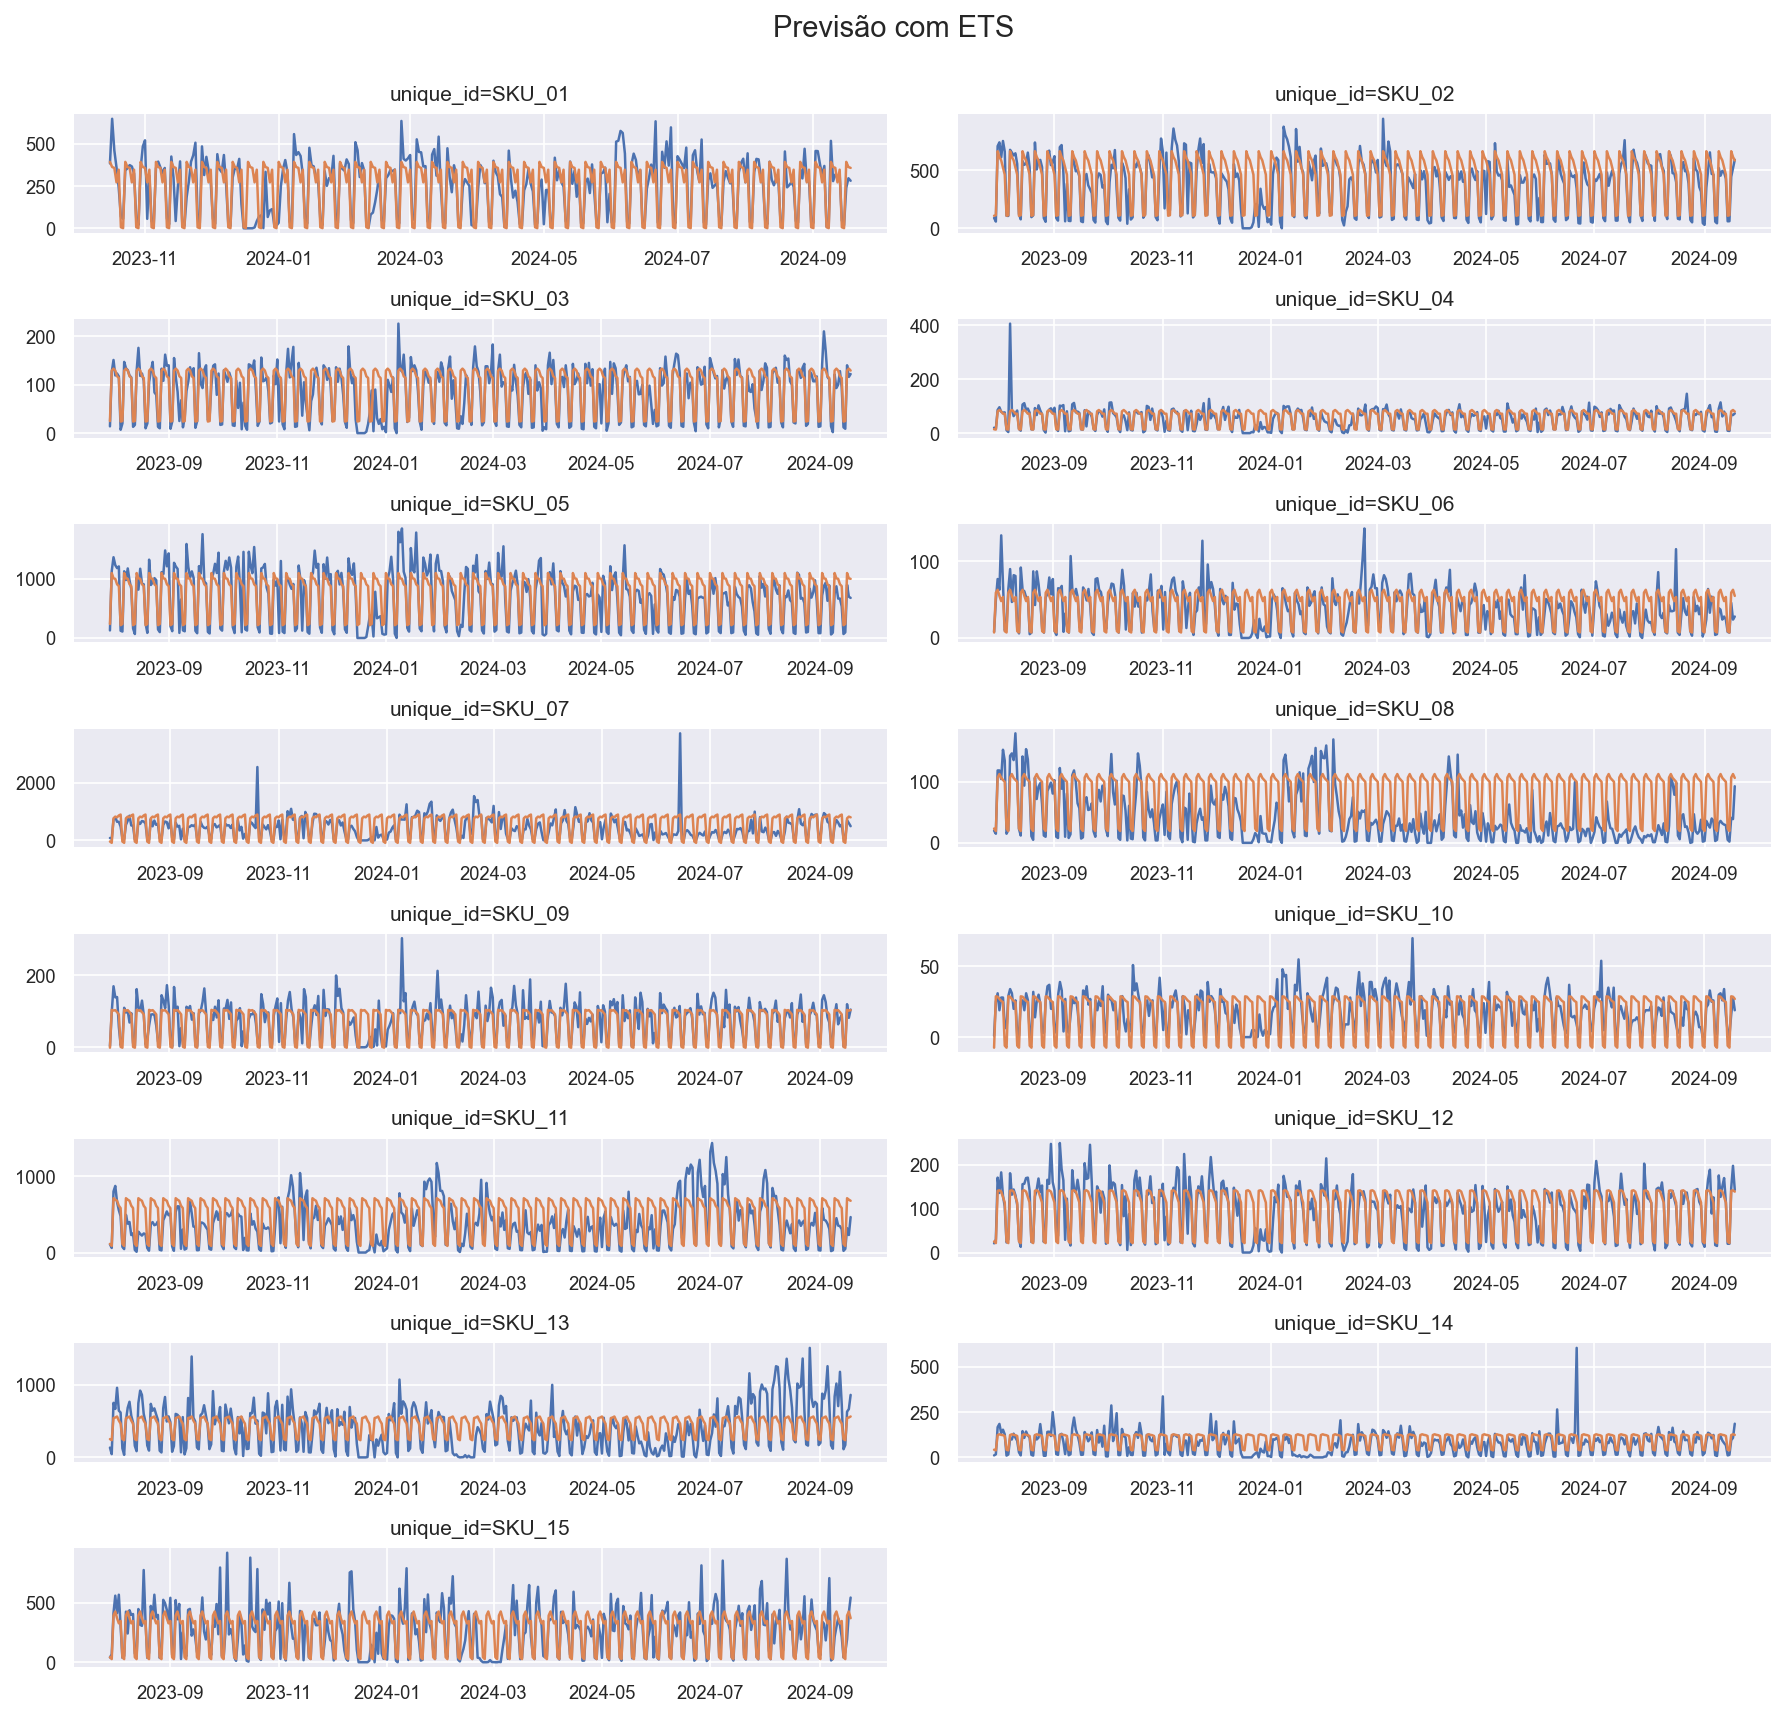

In [12]:
# plot das previsões ETS
fig4 = plot_time_series(
    df=baseline_fcst, data_cols=['y','ETS'], title='Previsão com ETS'
)

In [13]:
ets_eval = Evaluation(df=baseline_fcst, y_pred_col='ETS')
ets_eval.summary()
ets_eval.save_evaluation(EVAL_PATH, 'ETS')
ets_eval.evaluation_df

mae       mse   rmse    r2
SKU_01  73.90  11308.87 106.34  0.60
SKU_02 102.96  22224.44 149.08  0.58
SKU_03  22.01   1082.04  32.89  0.62
SKU_04  15.42    731.30  27.04  0.50
SKU_05 211.53  82603.71 287.41  0.61
SKU_06  14.23    402.58  20.06  0.43
SKU_07 279.56 142985.88 378.13  0.00
SKU_08  45.23   3019.06  54.95 -0.80
SKU_09  22.39   1089.22  33.00  0.59
SKU_10   8.81    114.48  10.70  0.28
SKU_11 212.41  70859.84 266.20  0.16
SKU_12  24.46   1353.07  36.78  0.62
SKU_13 196.91  63804.79 252.60  0.36
SKU_14  38.14   2902.89  53.88  0.27
SKU_15 103.61  22807.87 151.02  0.44

## **Regressão Linear Simples**
Uma abordagem do modelo de regressão linear aplicado a séries temporais pode ser visto em [Forecasting: Principles and Practice (3rd ed) - The linear model](https://otexts.com/fpp3/regression-intro.html).\
 Aqui, a única feature é o índice temporal dado por $x_t = t$, onde $t = 0, 1, 2 ... N$, sendo $N$ o número de observações na série.

In [14]:
def linear_regression(df : pd.DataFrame) -> pd.DataFrame:
    """
    Aplicação do modelo simples de regressão linear. Usa a ordem t como regressor.
    """    
    train = df.copy().reset_index(drop=True)
    fcst_df = test_df.query("unique_id == @train.unique_id[0]").reset_index(drop=True)
    fcst_df.index = fcst_df.index + train.index.max() + 1

    m = LinearRegression()
    m.fit(X=train.index.values.reshape(-1,1), 
          y=train.y)
    fcst_df['y_pred'] = m.predict(X=fcst_df.index.values.reshape(-1,1))

    return fcst_df

In [15]:
# aplicando modelo para cada série
lr_fcst = (
    train_df
        .groupby("unique_id")
        .apply(linear_regression)
        .reset_index(drop=True)
)

In [16]:
lr_eval = Evaluation(lr_fcst)
lr_eval.summary()
lr_eval.save_evaluation(EVAL_PATH, 'Reg. Linear')
lr_eval.evaluation_df

mae       mse   rmse    r2
SKU_01 153.29  36639.01 191.41 -0.30
SKU_02 192.06  56224.93 237.12 -0.07
SKU_03  44.95   3176.19  56.36 -0.13
SKU_04  30.02   1520.16  38.99 -0.05
SKU_05 480.30 295526.54 543.62 -0.38
SKU_06  25.02    915.32  30.25 -0.30
SKU_07 511.74 358960.95 599.13 -1.51
SKU_08  50.11   3082.87  55.52 -0.83
SKU_09  42.73   2683.24  51.80 -0.01
SKU_10  12.88    251.97  15.87 -0.58
SKU_11 381.62 184953.68 430.06 -1.20
SKU_12  50.37   3668.33  60.57 -0.04
SKU_13 295.31 138233.15 371.80 -0.39
SKU_14  48.76   4014.62  63.36 -0.01
SKU_15 188.48  52102.93 228.26 -0.27

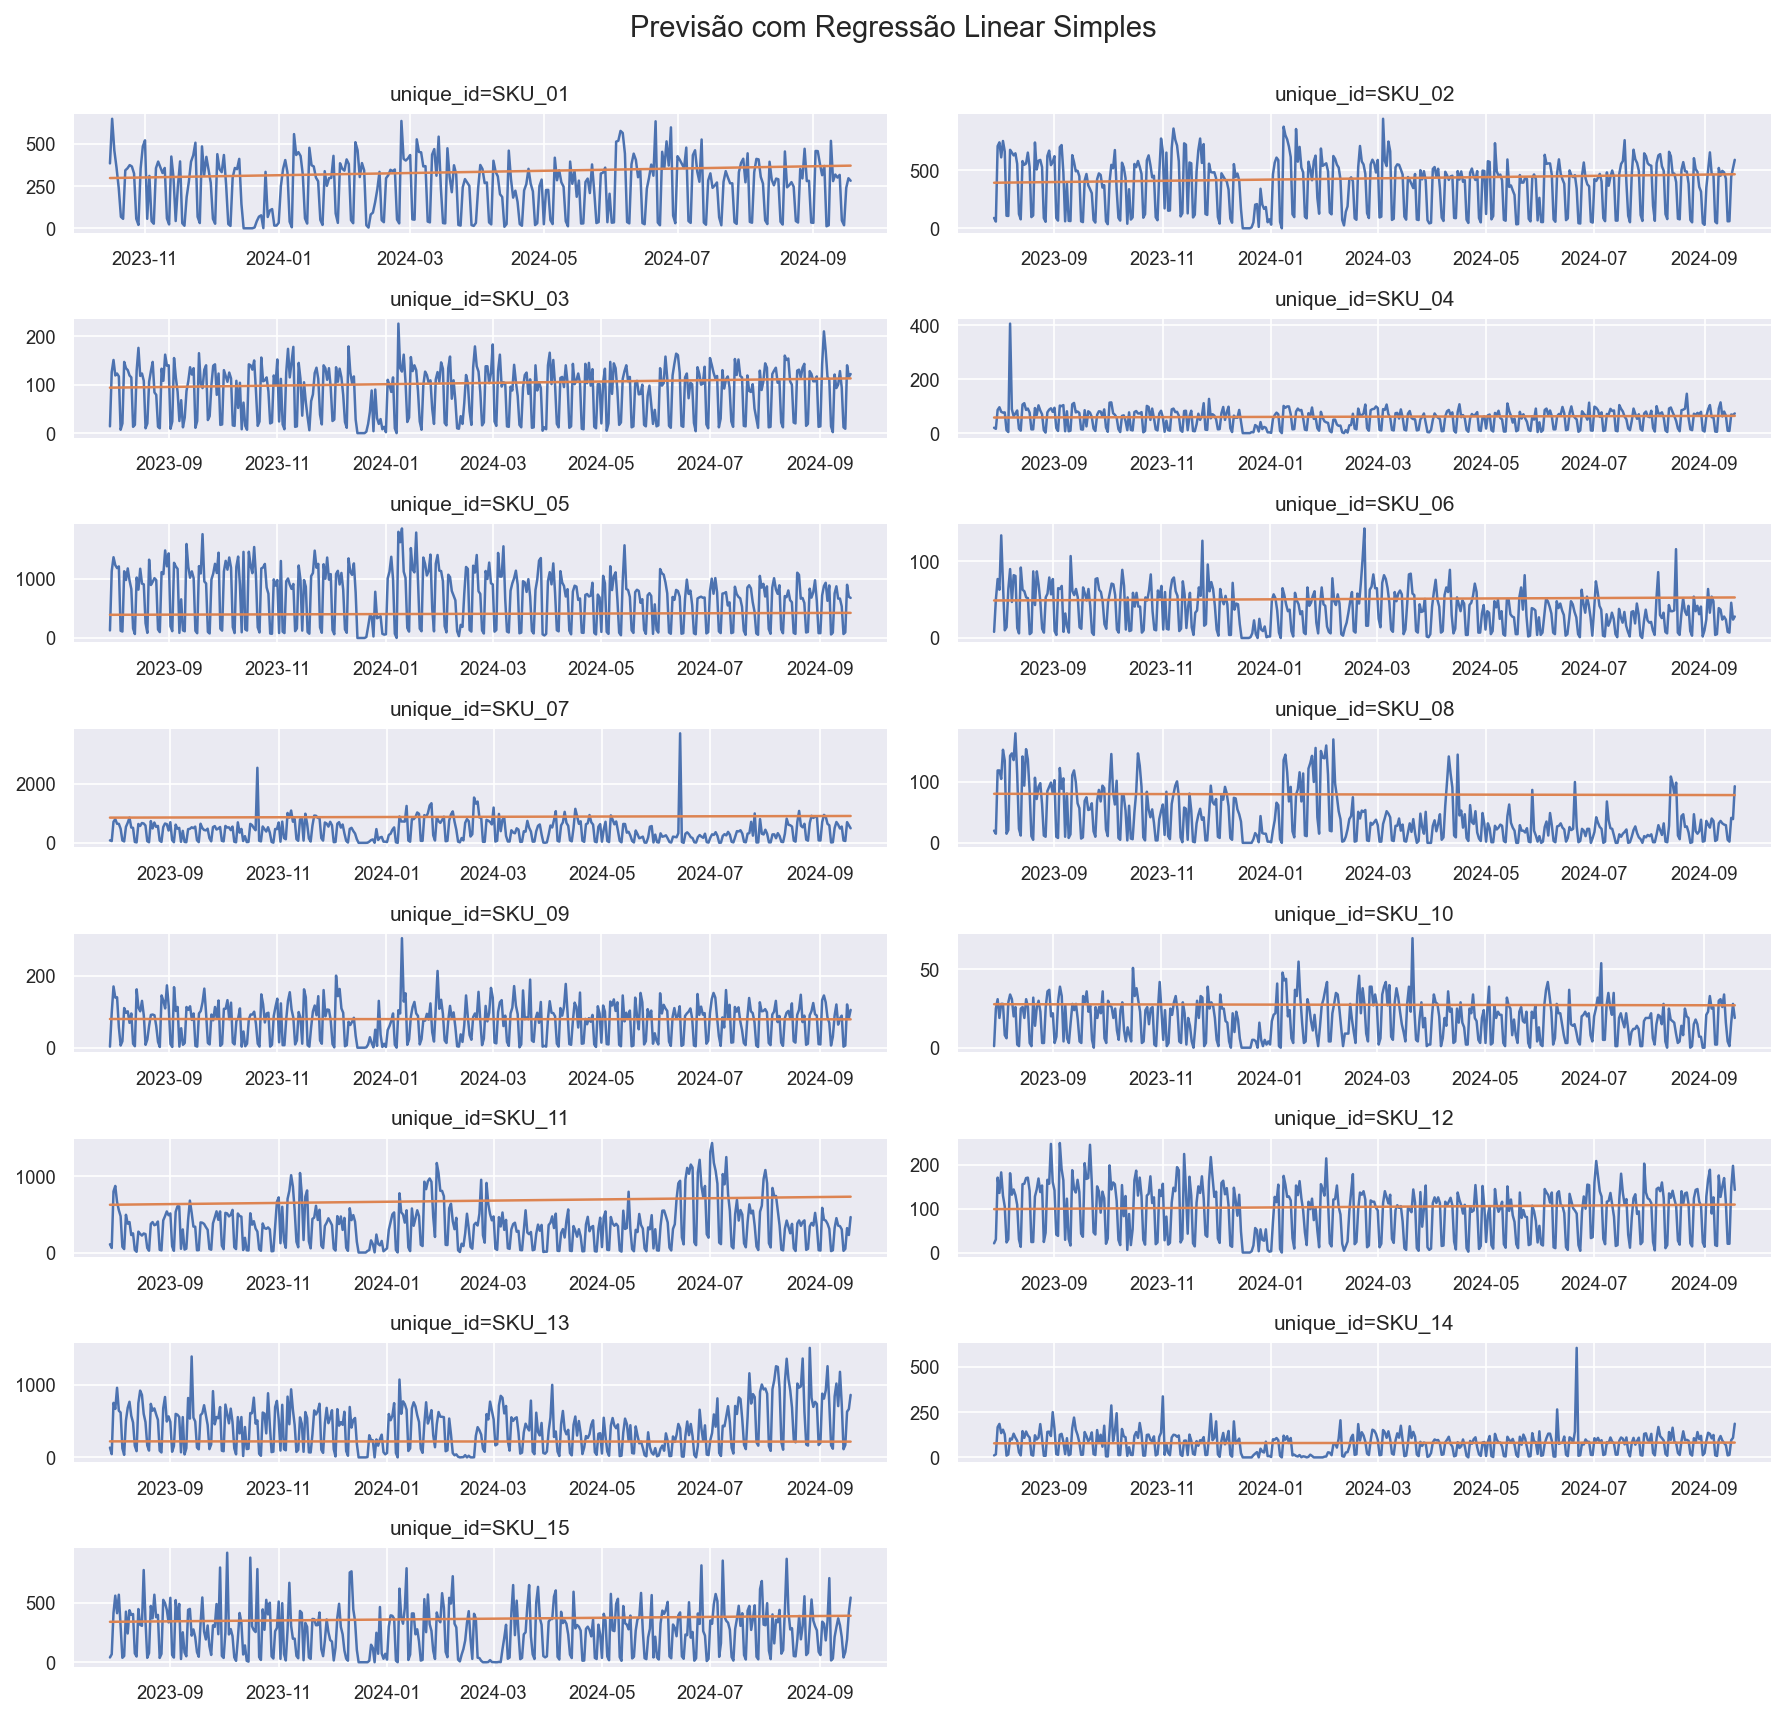

In [17]:
# plot das previsões 
fig5 = plot_time_series(
    df=lr_fcst, data_cols=['y', 'y_pred'], title='Previsão com Regressão Linear Simples'
)

## **Engenharia de Características**
Acrescentaremos algumas features para tentar captar a sazonalidade treinando um modelo de regressão linear múltipla.
Algums preditores são sugeridos em [Forecasting: Principles and Practice (3rd ed) - Useful Predictors](https://otexts.com/fpp3/useful-predictors.html).

In [ ]:
# inserindo as features nos dados de treino e teste
features_train_df = (
    train_df
    .groupby("unique_id")
    .apply(lambda x: add_calendar_features(df=x))
    .reset_index(drop=True)
)

features_test_df = (
    test_df
    .groupby("unique_id")
    .apply(lambda x: add_calendar_features(df=x))
    .reset_index(drop=True)
)

features_train_df = detect_outliers(features_train_df)
features_test_df.loc[:, ['max_outliers', 'min_outliers']] = 0

In [22]:
features_train_df.columns.tolist()

['unique_id',
 'ds',
 'y',
 'day',
 'month_end',
 'feriado',
 'day_of_week',
 'week',
 'month',
 'quarter',
 'max_outliers',
 'min_outliers']

In [23]:
features_test_df.columns.tolist()

['unique_id',
 'ds',
 'y',
 'day',
 'month_end',
 'feriado',
 'day_of_week',
 'week',
 'month',
 'quarter',
 'max_outliers',
 'min_outliers']

Para realizar regressão linear múltipla com dados com variáveis categóricas de calendário, convém transformá-las em variáveis dummy, conforme sugerido em [Forecasting: Principles and Practice (3rd ed) - Seasonal dummy variables](https://otexts.com/fpp3/useful-predictors.html#seasonal-dummy-variables).

In [24]:
categories = ['day', 'day_of_week', 'week', 'month', 'quarter']

encoder = OneHotEncoder(drop='first')
encoder.fit(features_train_df[categories])


# aplicando nos dados de treino
X_train_encoded = pd.DataFrame(
    data = encoder.transform(features_train_df[categories]).toarray(), 
    columns=encoder.get_feature_names_out()
)

encoded_train_df = pd.concat(
    [features_train_df.drop(columns=categories), X_train_encoded], 
    axis=1
)


# aplicando nos dados de teste
X_test_encoded = pd.DataFrame(
    data = encoder.transform(features_test_df[categories]).toarray(), 
    columns=encoder.get_feature_names_out()
)

encoded_test_df = pd.concat(
    [features_test_df.drop(columns=categories), X_test_encoded], 
    axis=1
)

In [25]:
encoded_train_df.columns

Index(['unique_id', 'ds', 'y', 'month_end', 'feriado', 'max_outliers',
       'min_outliers', 'day_2', 'day_3', 'day_4',
       ...
       'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11',
       'month_12', 'quarter_2', 'quarter_3', 'quarter_4'],
      dtype='object', length=109)

In [26]:
encoded_test_df.columns

Index(['unique_id', 'ds', 'y', 'month_end', 'feriado', 'max_outliers',
       'min_outliers', 'day_2', 'day_3', 'day_4',
       ...
       'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11',
       'month_12', 'quarter_2', 'quarter_3', 'quarter_4'],
      dtype='object', length=109)

## **Regressão Linear Múltipla**

In [27]:
def multiple_linear_regression(df : pd.DataFrame) -> pd.DataFrame:
    """
    Aplicação do modelo de regressão linear múltipla.
    """    
    train = df.copy().reset_index(drop=True)
    fcst_df = encoded_test_df.query("unique_id == @train.unique_id[0]").reset_index(drop=True)

    train['trend'] = train.index
    fcst_df['trend'] = fcst_df.index + train.index.max() + 1
    
    m = LinearRegression()
    m.fit(
        X=train.iloc[:,3:], 
        y=train.y
    )
    
    fcst_df['y_pred'] = m.predict(X=fcst_df.iloc[:,3:])

    return fcst_df

In [28]:
mlr_fcst = (
    encoded_train_df
    .groupby("unique_id")
    .apply(multiple_linear_regression)
    .reset_index(drop=True)
)

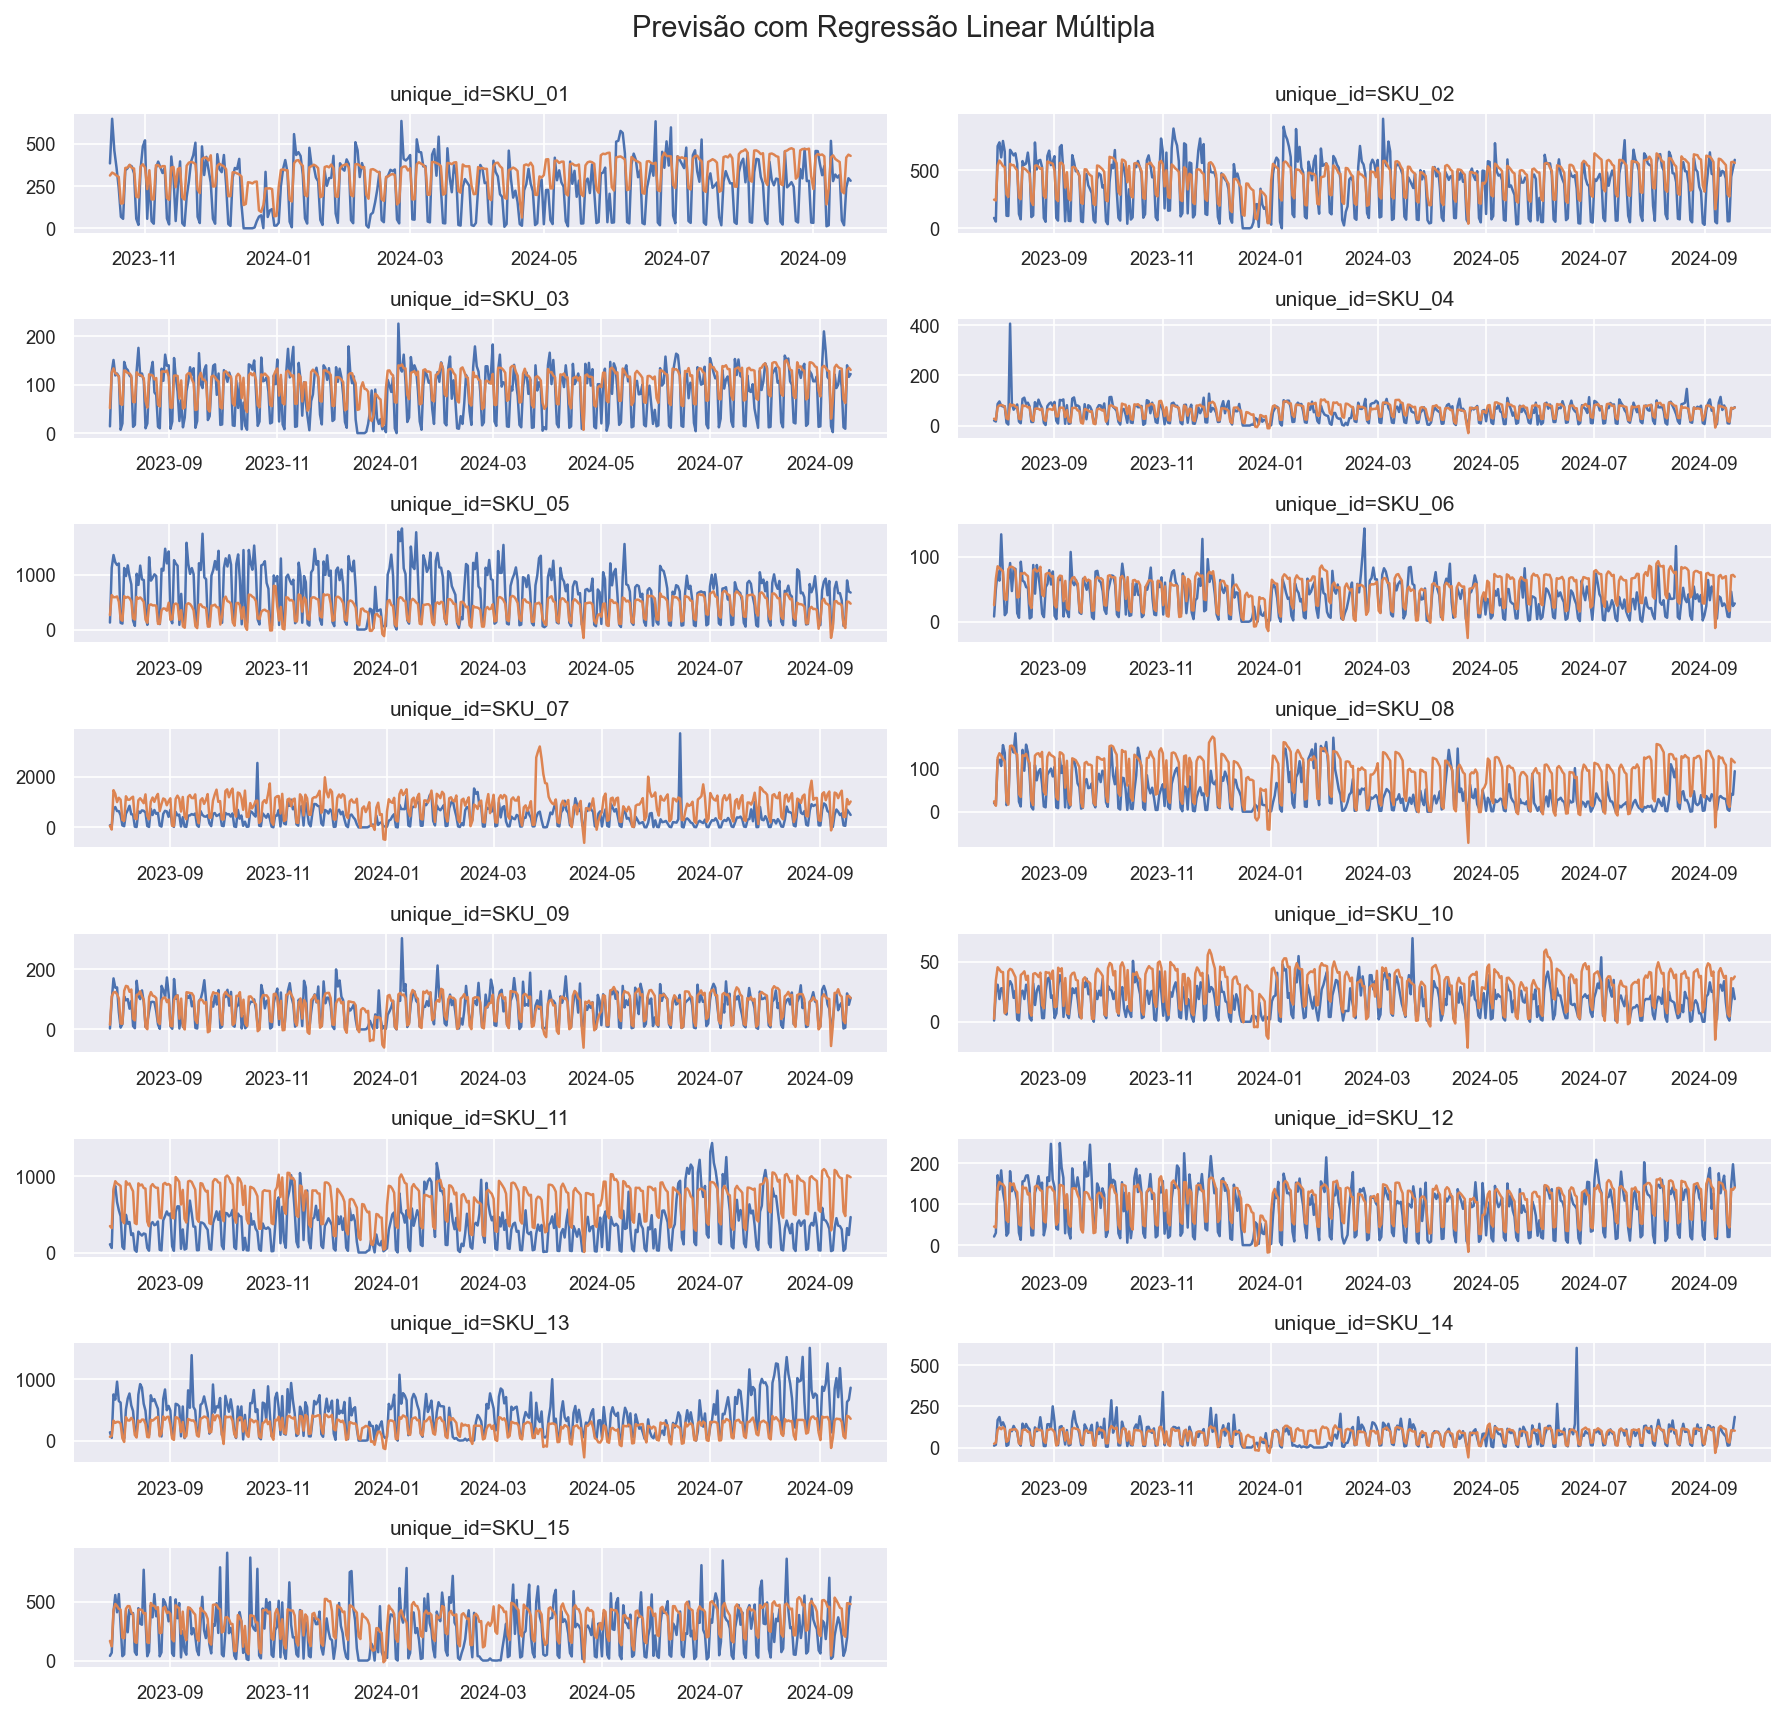

In [29]:
fig6 = plot_time_series(
    df = mlr_fcst, 
    data_cols=['y','y_pred'], 
    title='Previsão com Regressão Linear Múltipla'
)

In [ ]:
mlr_eval = Evaluation(mlr_fcst)
mlr_eval.summary()
mlr_eval.save_evaluation(EVAL_PATH, 'Reg. Linear Multipla')
mlr_eval.evaluation_df

mae       mse   rmse    r2
SKU_01 116.91  19125.83 138.30  0.32
SKU_02 121.56  21602.94 146.98  0.59
SKU_03  29.94   1347.60  36.71  0.52
SKU_04  18.55    745.98  27.31  0.49
SKU_05 340.08 198956.86 446.05  0.07
SKU_06  19.67    611.24  24.72  0.13
SKU_07 531.71 432987.87 658.02 -2.02
SKU_08  47.70   3349.55  57.88 -0.99
SKU_09  24.25   1079.94  32.86  0.59
SKU_10  13.39    252.54  15.89 -0.58
SKU_11 379.66 170508.95 412.93 -1.02
SKU_12  27.97   1211.32  34.80  0.66
SKU_13 222.69  90280.81 300.47  0.09
SKU_14  27.98   2213.53  47.05  0.45
SKU_15 140.90  29031.52 170.39  0.29

## **Comparação dos Modelos**

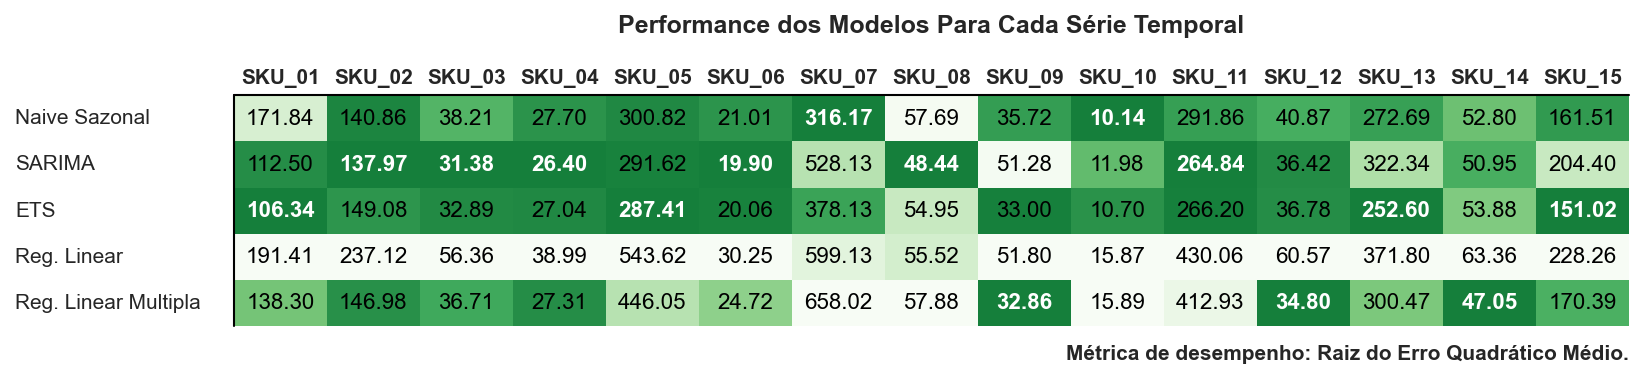

In [32]:
# comparação dos modelos
metrics = pd.read_csv(EVAL_PATH)
order = metrics['model'].unique()
metrics = metrics.pivot_table('rmse','unique_id','model')[order]

fig = plot_metrics(metrics, figsize=(12, 2))